In [2]:
%config Completer.use_jedi = False
import matplotlib
import pickle
import glob
import platform
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.metrics as skm
import sklearn.decomposition as skd
import pyts.image as pti
import pyts.approximation as pta
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rcparams(r=0.5):
    matplotlib.rcParams['mathtext.fontset'] = 'stix'
    matplotlib.rcParams['font.family'] = 'STIXGeneral'
    matplotlib.rcParams['font.size'] = 25 * r
    matplotlib.rcParams['xtick.labelsize'] = 20 * r
    matplotlib.rcParams['ytick.labelsize'] = 20 * r
    matplotlib.rcParams['axes.labelsize'] = 25 * r
    matplotlib.rcParams['legend.title_fontsize'] = 17 * r
    matplotlib.rcParams['legend.fontsize'] = 17 * r
    matplotlib.rcParams['axes.axisbelow'] = True
    matplotlib.rcParams['figure.figsize'] = [6 * r, 6 * r]

rcparams()

# format axis
def format_axis(ax):
    from matplotlib.ticker import (AutoMinorLocator)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(which='both', width=2)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)
    ax.locator_params(axis='x', nbins=5)
    ax.locator_params(axis='y', nbins=5)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(1.5)


### Define directories

In [11]:
osname = platform.system()
if osname == 'Darwin':
    data_dir = r'/Users/sjiang87/plastic/data/'
    weight_dir = r'/Users/sjiang87/plastic/weights/2nd/'
    result_dir = r'/Users/sjiang87/machinelearning2/plastic/result/'
elif osname == 'Windows':
    DATA_DIR = r'D:/plastic/data/'
    PLOT_DIR = r'D:/machinelearning2/plastic/result/figure/2nd/'
    weight_dir = r'D:/plastic/weights/2nd/'
    result_dir = r'D:/machinelearning2/plastic/result/'
elif osname == 'Linux':
    data_dir = r'./'
    weight_dir = r'./'
    result_dir = r'./'

### Create data with PC

In [37]:
files = glob.glob(DATA_DIR + '08-13-2021/PC training/*.txt')
data = []
for i in range(5000):
    df = pd.read_csv(files[i], skiprows=4, encoding='latin1', sep='\t')
    df = df.values[340:1940]
    wavelength = df[:, 0]
    data_temp = df[:, 1] - df[:, 2]
    data_temp /= 20
    p = np.polyfit(wavelength, data_temp, deg=1)
    data_temp -= wavelength*p[0] + p[1]
    data.append(data_temp)
data = np.array(data)
data.shape

(5000, 1600)

In [38]:
with open(DATA_DIR + 'fast.pickle', 'rb') as handle:
    x = pickle.load(handle)
    y = pickle.load(handle)
x = x[:, 340:1940]
x = np.concatenate((x, data), axis=0)
y = np.concatenate([y, np.ones(5000)*13])

In [40]:
# with open(DATA_DIR + 'fast_with_pc.pickle', 'wb') as handle:
#     pickle.dump(x, handle)
#     pickle.dump(y, handle)
#     pickle.dump(10000/wavelength, handle)

### Load data

In [6]:
%%time
with open(DATA_DIR + 'fast_with_pc.pickle', 'rb') as f:
    x = pickle.load(f)
    y = pickle.load(f)
    wavenumber = pickle.load(f)

x = np.concatenate([x[5000 * i:5000 * i + 100] for i in range(14)])
y = np.concatenate([y[5000 * i:5000 * i + 100] for i in range(14)])

x = (x - x.min()) / (x.max() - x.min())
# x = skp.minmax_scale(x, axis=1)
name = ['ABS/PC', 'ABS', 'HIPS', 'PA12', 'PE', 'PET', 'PLA', 'PMMA', 'POM', 'PP/PE/PS', 'PP', 'PS', 'PVC', 'PC']
colors = ['tab:gray', 'tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple', 'tab:brown', 'tab:pink',
          'tab:olive', 'tab:cyan', 'darkgreen', 'gold', 'tomato', 'violet', 'teal']

skf = skms.StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
i, k = 0, 1
for train_index, valid_index in skf.split(x, y):
    x_train, x_test = x[train_index], x[valid_index]
    y_train, y_test = y[train_index], y[valid_index]
    i += 1

x_train = np.random.RandomState(0).permutation(x_train)
x_test = np.random.RandomState(0).permutation(x_test)
y_train = np.random.RandomState(0).permutation(y_train)
y_test = np.random.RandomState(0).permutation(y_test)


Wall time: 465 ms


In [19]:
wavelength = np.linspace(1.8537, 5.7532, 2048)
wavenumber = 10000 / wavelength
print(np.where(wavenumber >= 1800)[0][-1])
print(np.where(wavenumber <= 4000)[0][0])

1943
340


### Prepare 2D data

In [2]:
# for i in [25, 50, 75, 100]:
#     with open(DATA_DIR + 'fast_with_pc.pickle', 'rb') as f:
#         x = pickle.load(f)
#         y = pickle.load(f)
#         wavenumber = pickle.load(f)
#     gasf = pti.GramianAngularField(image_size=i, method='summation')
#     gadf = pti.GramianAngularField(image_size=i, method='difference')
#     x1 = gasf.fit_transform(x)[..., np.newaxis]
#     x2 = gadf.fit_transform(x)[..., np.newaxis]
#     x3 = np.concatenate([x1, x2], axis=-1).astype(np.float32)

#     with open(DATA_DIR + f'fast_with_pc_{i}.pickle', 'wb') as f:
#         pickle.dump(x3, f)
#         pickle.dump(y, f)
#         pickle.dump(wavenumber, f)

### Prepare multilabel

In [7]:
# mlb = skp.MultiLabelBinarizer()

# y = mlb.fit_transform([['ABS', 'PC'],
#                        ['ABS'],
#                        ['HIPS'],
#                        ['PA12'],
#                        ['PE'],
#                        ['PET'],
#                        ['PLA'],
#                        ['PMMA'],
#                        ['POM'],
#                        ['PP', 'PE', 'PS'],
#                        ['PP'],
#                        ['PS'],
#                        ['PVC'],
#                        ['PC']])

# y = np.repeat(y, 5000, axis=0)

# with open(DATA_DIR + 'fast_with_pc_multilabel.pickle', 'wb') as f:
#     pickle.dump(y, f)

### Prepare revalidation PE, PET data

In [32]:
with open(DATA_DIR + "angle_starch_train.pickle", "rb") as f:
    x = pickle.load(f)
    y = pickle.load(f)
x = x[65000:75000][:, 340:1940]
y = y[65000:75000]
wavenumber = wavenumber[340:1940]

for i in [25, 50, 75, 100]:
    gasf = pti.GramianAngularField(image_size=i, method='summation')
    gadf = pti.GramianAngularField(image_size=i, method='difference')
    x1 = gasf.fit_transform(x)[..., np.newaxis]
    x2 = gadf.fit_transform(x)[..., np.newaxis]
    x3 = np.concatenate([x1, x2], axis=-1).astype(np.float32)

    with open(DATA_DIR + f'revalidate_fast_with_pc_{i}.pickle', 'wb') as f:
        pickle.dump(x3, f)
        pickle.dump(y, f)
        pickle.dump(wavenumber, f)

In [33]:
with open(DATA_DIR + f'revalidate_fast_with_pc.pickle', 'wb') as f:
    pickle.dump(x, f)
    pickle.dump(y, f)
    pickle.dump(wavenumber, f)

In [34]:
with open(DATA_DIR + "angle_starch_test.pickle", "rb") as f:
    x = pickle.load(f)
    y = pickle.load(f)
x = x[:5000][:, 340:1940]
y = y[:5000]

with open(DATA_DIR + f'revalidate_fast_with_pc_test.pickle', 'wb') as f:
    pickle.dump(x, f)
    pickle.dump(y, f)
    pickle.dump(wavenumber, f)

In [35]:
for i in [25, 50, 75, 100]:
    gasf = pti.GramianAngularField(image_size=i, method='summation')
    gadf = pti.GramianAngularField(image_size=i, method='difference')
    x1 = gasf.fit_transform(x)[..., np.newaxis]
    x2 = gadf.fit_transform(x)[..., np.newaxis]
    x3 = np.concatenate([x1, x2], axis=-1).astype(np.float32)

    with open(DATA_DIR + f'revalidate_fast_with_pc_{i}_test.pickle', 'wb') as f:
        pickle.dump(x3, f)
        pickle.dump(y, f)
        pickle.dump(wavenumber, f)

### Plot data

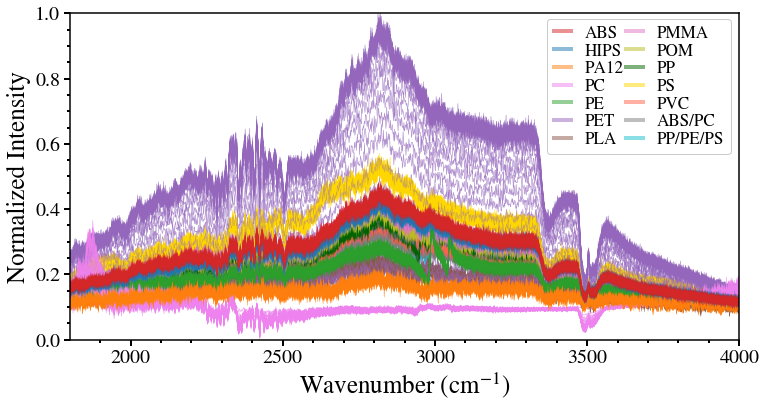

CPU times: user 13.2 s, sys: 87.9 ms, total: 13.3 s
Wall time: 13.3 s


In [20]:
%%time
rcparams(1)
fig, ax = plt.subplots(figsize=(12, 6))
wavenumber = np.linspace(1800, 4000, 1600)
for i in [1, 2, 3, 13, 4, 5, 6, 7, 8, 10, 11, 12, 0, 9]:
    idx = np.where(y == i)[0]
    x_temp = x[idx]
    for j in range(50):
        if j == 0:
            ax.plot(wavenumber, x_temp[j], c=colors[i], linewidth=0.5, label=name[i], alpha=0.5)
        else:
            ax.plot(wavenumber, x_temp[j], c=colors[i], linewidth=0.5, alpha=0.5)

for i in reversed([1, 2, 3, 13, 4, 5, 6, 7, 8, 10, 11, 12, 0, 9]):
    idx = np.where(y == i)[0]
    x_temp = x[idx]
    for j in range(50):
        ax.plot(wavenumber, x_temp[j], c=colors[i], linewidth=0.5, alpha=0.5)

ax.set_xlim([1800, 4000])
ax.set_ylim([0, 1])

leg = plt.legend(ncol=2, bbox_to_anchor=(0.70, 1.01), loc='upper left', columnspacing=0.15, 
                 handlelength=1.0, labelspacing=0.1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
leg.get_frame().set_alpha(None)
leg.get_frame().set_facecolor((0, 0, 0, 0.0))

ax.set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax.set_ylabel(r'Normalized Intensity')
format_axis(ax)
plt.savefig(PLOT_DIR + 'spectrum.svg', bbox_inches='tight')
plt.savefig(PLOT_DIR + 'spectrum.png', bbox_inches='tight', dpi=300)
plt.show()


### Transform to Gramian angular fields

In [32]:
%%time
gasf = pti.GramianAngularField(image_size=100, method='summation')
gadf = pti.GramianAngularField(image_size=100, method='difference')

x_train1 = gasf.fit_transform(x_train)[..., np.newaxis]
x_test1 = gasf.transform(x_test)[..., np.newaxis]

x_train2 = gadf.fit_transform(x_train)[..., np.newaxis]
x_test2 = gadf.transform(x_test)[..., np.newaxis]

x_train_2d = np.concatenate([x_train1, x_train2], axis=-1)

CPU times: user 1.67 s, sys: 81.9 ms, total: 1.75 s
Wall time: 1.74 s


### Plot example intensity curve

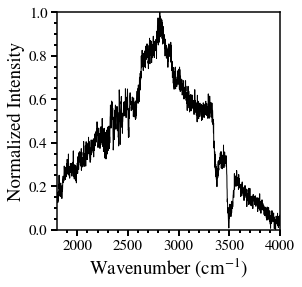

Wall time: 388 ms


In [12]:
%%time
x_1d = np.copy(x_train[1])
x_1d = skp.minmax_scale(x_1d)
wavenumber = np.linspace(1800, 4000, 1600)
rcparams(0.75)
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(wavenumber, x_1d, linewidth=1, alpha=1, c='k')

ax.set_xlim([1800, 4000])
ax.set_ylim([0, 1])
ax.set_xlabel(r'Wavenumber (cm$^{-1}$)')
ax.set_ylabel(r'Normalized Intensity')
format_axis(ax)
plt.savefig(PLOT_DIR + '1DSignal.svg', bbox_inches='tight')

plt.show()

### Plot polar representation

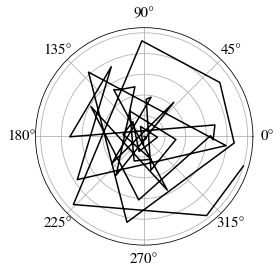

Wall time: 1.23 s


In [13]:
%%time
paa = pta.PiecewiseAggregateApproximation(window_size=41)

x_train1 = x_1d[np.newaxis, ...]
x_paa = paa.transform(x_train1).squeeze()

theta = np.arccos(x_paa)
r = np.linspace(0, 1, len(x_paa))

rcparams(0.75)
fig = plt.figure(figsize=(4, 4))
ax = plt.subplot(1, 1, 1, projection='polar')
ax.plot(theta*180/np.pi, r, 'k-', linewidth=1.5)
ax.set_yticklabels([])

plt.savefig(PLOT_DIR + '1DSignalPolar.svg', bbox_inches='tight')
plt.show()

### Plot 2-channel GAF 

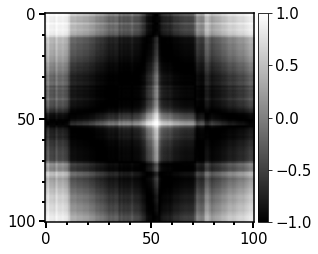

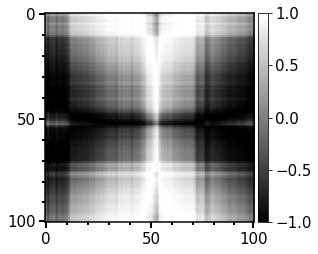

CPU times: user 481 ms, sys: 13 ms, total: 494 ms
Wall time: 489 ms


In [33]:
%%time
# GASF
rcparams(0.75)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(x_train_2d[1, ..., 0], cmap='gray', vmin=-1, vmax=1)
plt.xticks([0, 50, 99], [0, 50, 100])
plt.yticks([0, 50, 99], [0, 50, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
format_axis(ax)
# plt.savefig(PLOT_DIR + 'GASF.svg', bbox_inches='tight')
plt.show()

# GADF
rcparams(0.75)
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(x_train_2d[1, ..., 1], cmap='gray', vmin=-1, vmax=1)
plt.xticks([0, 50, 99], [0, 50, 100])
plt.yticks([0, 50, 99], [0, 50, 100])
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
plt.colorbar(im, cax=cax)
format_axis(ax)
# plt.savefig(PLOT_DIR + 'GADF.svg', bbox_inches='tight')
plt.show()

### PCA clustering

In [37]:
%%time
pca = skd.PCA(n_components=2)
ss = skp.StandardScaler()

with open(DATA_DIR + 'fast.pickle', 'rb') as f:
    x = pickle.load(f)
    y = pickle.load(f)
    
x = ss.fit_transform(x.T).T
x_pca = pca.fit_transform(x)


CPU times: user 32.7 s, sys: 8.11 s, total: 40.8 s
Wall time: 9.09 s


### Plot clustering

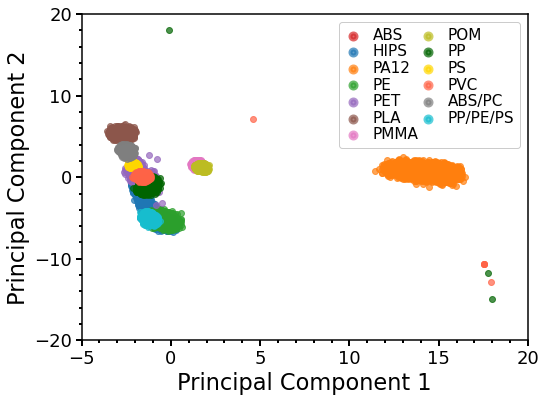

CPU times: user 482 ms, sys: 6.94 ms, total: 489 ms
Wall time: 488 ms


In [47]:
%%time
rcparams(0.9)
fig, ax = plt.subplots(figsize=(8, 6))

for i in [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 0, 9]:
    idx = np.where(y == i)[0]
    ax.scatter(x_pca[idx, 0], x_pca[idx, 1], alpha=0.7, label=name[i], c=colors[i])

ax.set_xlim([-5, 20])
ax.set_ylim([-20, 20])

leg = plt.legend(ncol=2, loc='upper right', columnspacing=0.1, handlelength=1.0,
                 labelspacing=0.1)
for legobj in leg.legendHandles:
    legobj.set_linewidth(4.0)
leg.get_frame().set_alpha(None)
leg.get_frame().set_facecolor((0, 0, 0, 0.0))

ax.set_xlabel(r'Principal Component 1')
ax.set_ylabel(r'Principal Component 2')
format_axis(ax)

# plt.savefig(PLOT_DIR + 'pca.svg', bbox_inches='tight')

plt.show()
